# Session 4: Laboratory Session II - Automated Signal Classification

**Topic:** Predictive Maintenance & Signal Classification  
**Dataset:** Sonar "Mines vs. Rocks" (UCI Machine Learning Repository)  
**Objective:** Design a binary classification system that can distinguish between a Metal Cylinder (Mine) and a Rock using sonar return signals.

---

## 1. Introduction & Context

In this session, we are simulating a safety-critical engineering task. We have raw sensor data—specifically, sonar signals bouncing off objects underwater.

* **The Scenario:** A submarine emits a "chirp" (sound signal). The signal hits an object and bounces back.
* **The Input:** 60 numerical readings representing the energy of the echo across different frequency bands.
* **The Output:** A prediction: Is it a **Rock (R)** or a **Mine (M)**?

Our goal is to build a model that performs better than random guessing and, crucially, minimizes dangerous errors (like missing a mine).

### Why Machine Learning?
Raw sensor data is often too "noisy" for humans to interpret visually. We need algorithms to find hidden patterns in the frequencies.

In [1]:
# Step 1: Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Scikit-learn modules for modeling and evaluation
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# Configure plotting style for better visuals
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

print("Libraries imported successfully!")

Libraries imported successfully!


## 2. Load and Inspect the Data

We will load the data directly from the UCI Machine Learning repository. This dataset contains 208 samples.

In [2]:
# Load dataset from URL (The dataset has no headers, so we set header=None)
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/undocumented/connectionist-bench/sonar/sonar.all-data"
df = pd.read_csv(url, header=None)

# Quick inspection
print(f"Dataset Shape: {df.shape} (Rows, Columns)")
print("\nFirst 5 rows of the data:")
# Columns 0-59 are sensor readings. Column 60 is the label (M or R)
df.head()

Dataset Shape: (208, 61) (Rows, Columns)

First 5 rows of the data:


,0,1,2,3,4,5,6,7,8,9,...,51,52,53,54,55,56,57,58,59,60
0,0.0200,0.0371,0.0428,0.0207,0.0954,0.0986,0.1539,0.1601,0.3109,0.2111,...,0.0027,0.0065,0.0159,0.0072,0.0167,0.0180,0.0084,0.0090,0.0032,R
1,0.0453,0.0523,0.0843,0.0689,0.1183,0.2583,0.2156,0.3481,0.3337,0.2872,...,0.0084,0.0089,0.0048,0.0094,0.0191,0.0140,0.0049,0.0052,0.0044,R
2,0.0262,0.0582,0.1099,0.1083,0.0974,0.2280,0.2431,0.3771,0.5598,0.6194,...,0.0232,0.0166,0.0095,0.0180,0.0244,0.0316,0.0164,0.0095,0.0078,R
3,0.0100,0.0171,0.0623,0.0205,0.0205,0.0368,0.1098,0.1276,0.0598,0.1264,...,0.0121,0.0036,0.0150,0.0085,0.0073,0.0050,0.0044,0.0040,0.0117,R
4,0.0762,0.0666,0.0481,0.0394,0.0590,0.0649,0.1209,0.2467,0.3564,0.4459,...,0.0031,0.0054,0.0105,0.0110,0.0015,0.0072,0.0048,0.0107,0.0094,R


## 3. The "Engineer's View": Visualizing the Signals

Before training a model, an engineer must understand the physical data.

Let's plot the raw signal of a **Mine** versus a **Rock** to see if we can distinguish them with the naked eye.
* **X-Axis:** Frequency Band (0 to 59)
* **Y-Axis:** Energy Level (Normalized 0.0 to 1.0)

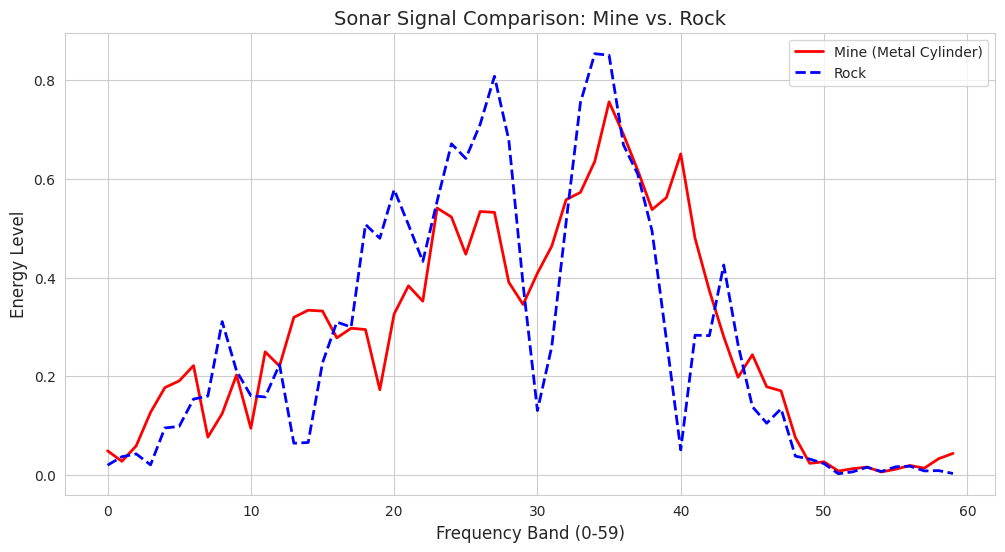

In [3]:
# Separate the data by class for plotting
# We select all columns except the last one (iloc[:, :-1]) for plotting features
mines = df[df[60] == 'M'].iloc[:, :-1]
rocks = df[df[60] == 'R'].iloc[:, :-1]

# Plot a single sample of a Mine vs a Rock
plt.figure(figsize=(12, 6))

# Plot the first Mine sample in the dataset
plt.plot(mines.iloc[0], label='Mine (Metal Cylinder)', color='red', linewidth=2)

# Plot the first Rock sample in the dataset
plt.plot(rocks.iloc[0], label='Rock', color='blue', linestyle='--', linewidth=2)

plt.title("Sonar Signal Comparison: Mine vs. Rock", fontsize=14)
plt.xlabel("Frequency Band (0-59)", fontsize=12)
plt.ylabel("Energy Level", fontsize=12)
plt.legend()
plt.show()

**Discussion:**
Notice how "noisy" the signals are. While there are some differences (peaks and valleys), writing a manual rule (e.g., *"If energy at band 20 is > 0.5..."*) would be unreliable. This is why we need Machine Learning to find the complex boundary between these two signal types.

## 4. Data Preprocessing

We need to convert our labels ('M' and 'R') into numbers (1 and 0) and split our data into a **Training Set** (for the model to learn) and a **Test Set** (to evaluate performance).

In [4]:
# 1. Separate Features (X) and Labels (y)
X = df.iloc[:, :-1].values  # All 60 sensor readings
y = df.iloc[:, -1].values   # The 'M' or 'R' label

# 2. Encode labels: Map Mine (M) -> 1 and Rock (R) -> 0
# This helps in calculating metrics later
y = np.where(y == 'M', 1, 0)

# 3. Train/Test Split (80% Train, 20% Test)
# random_state=42 ensures we all get the same random split for this workshop
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Training samples: {X_train.shape[0]}")
print(f"Testing samples:  {X_test.shape[0]}")

Training samples: 166
Testing samples:  42


## 5. Baseline Model: Logistic Regression

As discussed in **Session 2**, Logistic Regression tries to separate the two classes using a **Linear Decision Boundary** (a straight line or hyperplane).

Let's see how well a simple linear model works on this complex frequency data.

In [5]:
# Initialize the model
log_model = LogisticRegression()

# Train the model on the training data
log_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred_log = log_model.predict(X_test)

# Evaluate Accuracy
acc_log = accuracy_score(y_test, y_pred_log)
print(f"Logistic Regression Accuracy: {acc_log:.2%}")

Logistic Regression Accuracy: 78.57%


**Observation:** An accuracy between **70-80%** is typical here. It's decent, but in a safety-critical system, a 20-30% error rate could be catastrophic. The limitation is that Logistic Regression assumes the data can be separated by a straight line.

## 6. The Advanced Model: Support Vector Machines (SVM)

Now we apply **SVM**. We will start with a basic Linear SVM and then use the **Kernel Trick (RBF)** to capture non-linear relationships.

In [6]:
# 6a. Linear SVM
# This performs similarly to Logistic Regression because it's still looking for a straight line.
svm_linear = SVC(kernel='linear', random_state=42)
svm_linear.fit(X_train, y_train)
y_pred_linear = svm_linear.predict(X_test)

print(f"Linear SVM Accuracy: {accuracy_score(y_test, y_pred_linear):.2%}")

Linear SVM Accuracy: 85.71%


### 6b. The Kernel Trick (RBF Kernel)
Now we use the **Radial Basis Function (RBF)** kernel.

* **Concept:** This maps our 60 features into a higher-dimensional space where the Mines and Rocks are easier to separate.

In [7]:
# RBF Kernel (Radial Basis Function)
# C=10: Allows the model to fit the training data more closely (less regularization)
# gamma='scale': Automatically adjusts based on feature variance
svm_rbf = SVC(kernel='rbf', C=10, gamma='scale', random_state=42)

svm_rbf.fit(X_train, y_train)
y_pred_rbf = svm_rbf.predict(X_test)

print(f"RBF SVM Accuracy: {accuracy_score(y_test, y_pred_rbf):.2%}")

RBF SVM Accuracy: 90.48%


**Result:** You should see a significant jump in accuracy (often to **85-90%**). This proves that the relationship between sonar frequency and material type is **non-linear**, which is why the SVM Kernel is superior here.

## 7. Safety-Critical Evaluation: The Confusion Matrix

Accuracy isn't everything. In engineering, different errors have different costs.

* **False Positive (Type I):** We predict Mine, but it's a Rock.  
    *Cost:* Wasted time, wasted torpedo, panic.
* **False Negative (Type II):** We predict Rock, but it's a **Mine**.  
    *Cost:* **Explosion / Mission Failure.**

We must visualize these errors to understand the safety of our system.

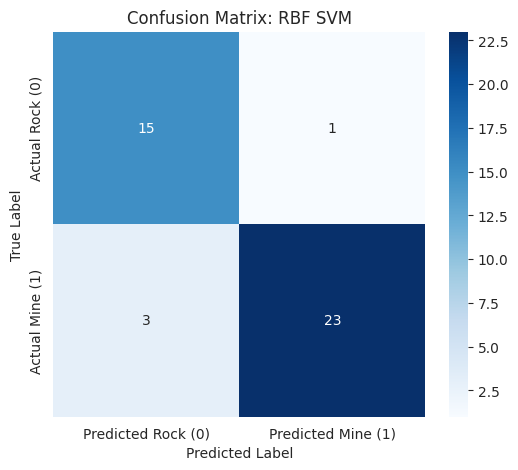

In [8]:
# Create the confusion matrix for our best model (RBF SVM)
cm = confusion_matrix(y_test, y_pred_rbf)

# Visualize it nicely using a Heatmap
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Predicted Rock (0)', 'Predicted Mine (1)'],
            yticklabels=['Actual Rock (0)', 'Actual Mine (1)'])
plt.title('Confusion Matrix: RBF SVM')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

### Interpreting the Matrix:
1.  **Top-Left:** True Negatives (Correctly identified Rocks).
2.  **Bottom-Right:** True Positives (Correctly identified Mines).
3.  **Bottom-Left (False Negatives):** The Dangerous Box. These are Mines we missed.
4.  **Top-Right (False Positives):** The False Alarms.

**Question:** Does our model miss any Mines? If so, can we fix it?

## 8. Challenge: The "Safety-First" Model

We can force the SVM to pay more attention to Mines by using `class_weight`. We penalize the model more heavily for missing a Mine (Class 1) than for missing a Rock (Class 0).

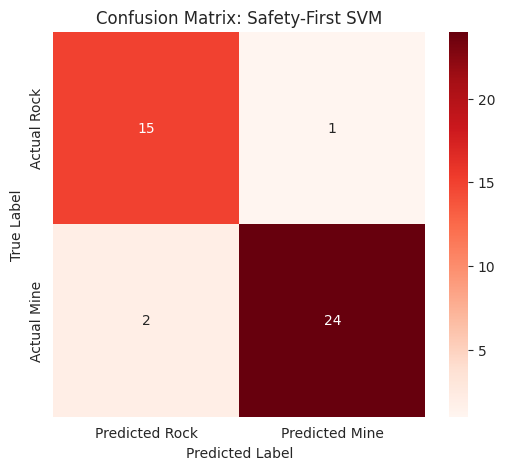

In [9]:
# We give Class 1 (Mine) a weight of 2, and Class 0 (Rock) a weight of 1.
# This tells the SVM: "A mistake on a Mine is twice as bad as a mistake on a Rock."
svm_safety = SVC(kernel='rbf', C=10, class_weight={1: 2, 0: 1}, random_state=42)
svm_safety.fit(X_train, y_train)
y_pred_safety = svm_safety.predict(X_test)

# Let's look at the confusion matrix again
cm_safety = confusion_matrix(y_test, y_pred_safety)

plt.figure(figsize=(6, 5))
sns.heatmap(cm_safety, annot=True, fmt='d', cmap='Reds',
            xticklabels=['Predicted Rock', 'Predicted Mine'],
            yticklabels=['Actual Rock', 'Actual Mine'])
plt.title('Confusion Matrix: Safety-First SVM')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

**Conclusion:**
By adjusting weights, we might increase False Positives (False Alarms), but we often reduce False Negatives (Missed Mines). In engineering, this trade-off is often necessary for safety.